In [2]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_MOI2D, get_Pendulum_Invariance, get_SHM_Invariance, get_SHM2D_Invariance, get_Double_Pendulum_Invariance
from invariance_functions import degree_of_freedom, get_GPR_2Dmodel, get_SHM2D_data, evaluate_2Dmodel, get_double_pendulum_data
from local_invariance_kernels import  get_Polynomial_2D_Local_Invariance
from parameterised_invariance_kernels import get_Polynomial_2D_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [6]:
mean = zero_mean(4)

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 120
n_train = 5
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5, (n_train))
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)

data = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch
test_data = get_double_pendulum_data(time_step, testing_time, 1e-8,[test_starting_position1],[test_starting_position2],[test_starting_velocity1],[test_starting_velocity2] )
for jitter in [1e-5]:
    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
    print(evaluate_moi[:2])
    for invar_density in [8]: #np.arange(10, 30, 10):
            try:
                polynomial_degree = 4
#                kernel = get_Polynomial_2D_Local_Invariance(3, 40, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                kernel = get_Polynomial_2D_Invariance(3, invar_density, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                m = get_GPR_2Dmodel(kernel, mean, data, 1000)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])
                print(kernel.f1_poly)
                print(kernel.f2_poly)
                print(kernel.g1_poly)
                print(kernel.g2_poly)

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 


[  96.38685109  -58.33953001 -110.87529323  -80.47791266  -84.97250252]
[  -1.41439225  -63.09786888   27.11667183   98.10557407 -101.75157133]
[-14.32497451  16.5070674  -12.36872278  20.03984367  -5.20426918]
[-21.68748708 -23.41687211  -8.73345278 -10.0792997   10.51038225]
4.797315248044086
-57.24677332660701
-14.915086537721109
14.083014890631155
749, 
(0.471263579369508, 0.12370460373504687)
756
(0.36049183875733615, 0.20702452812616873)
<Parameter: name=sigmoid, dtype=float64, shape=[69, 1], fn="sigmoid", numpy=
array([[ 4.86882205e-05],
       [-9.60434535e-04],
       [ 1.75098522e-03],
       [-1.77866033e-04],
       [-9.45222487e-06],
       [ 5.06004119e-04],
       [ 1.94101855e-04],
       [-9.48259447e-05],
       [ 6.83639367e-04],
       [-1.51298365e-04],
       [ 2.27227341e-04],
       [ 2.09676460e-03],
       [-6.07045556e-05],
       [ 1.05756660e-03],
       [ 4.37600649e-03],
       [-1.31233315e-04],
       [-5.27493264e-05],
       [-2.51916889e-05],
       

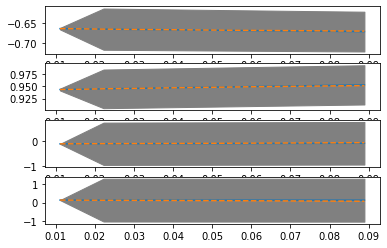

In [3]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[2][:,0])
axs[0].fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_moi[2][:,1])
axs[1].fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_moi[2][:,2])
axs[2].fill_between(t,evaluate_moi[2][:,2]+1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,2]-1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_moi[2][:,3])
axs[3].fill_between(t,evaluate_moi[2][:,3]+1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,3]-1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

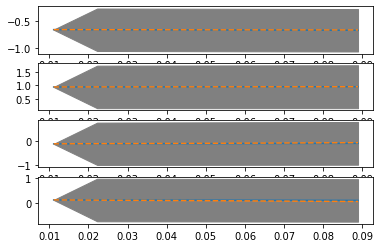

In [4]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')